In [ ]:
# install requirements
!pip install falkordb openai sf-hamilton[sdk,visualization] 

# Ingestion Notebook

In this notebook we see how to load data into FalkorDB using [Hamilton](https://github.com/dagWorks-Inc/hamilton).

In [4]:
# load jupyter magic to help display Hamilton in a notebook
%load_ext hamilton.plugins.jupyter_magic

The hamilton.plugins.jupyter_magic extension is already loaded. To reload it, use:
  %reload_ext hamilton.plugins.jupyter_magic


## Fighter ingestion pipeline

We define loading a CSV, then loading each row/fighter into FalkorDB.

We use Hamilton to parallelize & iterate over each fighter to keep our code more unit testable and manageable. 

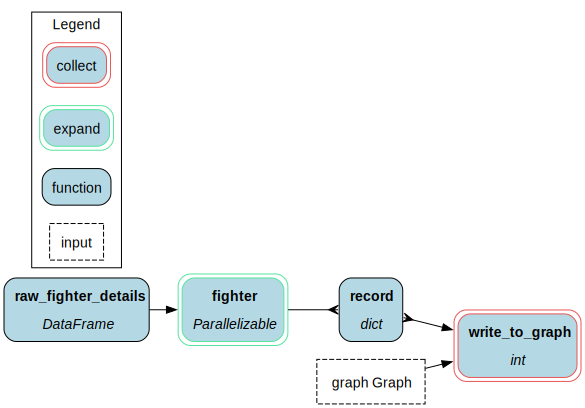

In [5]:
%%cell_to_module -m load_fighters --display

import pandas as pd
from hamilton.htypes import Parallelizable, Collect
import falkordb
import utils

def raw_fighter_details() -> pd.DataFrame:
    """Load fighter data"""
    _df = pd.read_csv('../data/raw_fighter_details.csv')
    return _df

def fighter(raw_fighter_details: pd.DataFrame) -> Parallelizable[pd.Series]:
    """We then want to do something for each record. That's what this code sets up"""
    for idx, row in raw_fighter_details.iterrows():
        yield row

def record(fighter: pd.Series) -> dict:
    """Given a single fighter record, process it into a dictionary."""
    attrs = {}
    attrs['Name'] = fighter.fighter_name
    
    if isinstance(fighter.Height, str) and fighter.Height != "":
        attrs['Height'] = utils.height_to_cm(fighter.Height)
    
    if isinstance(fighter.Weight, str) and fighter.Weight != "":
        Weight = int(fighter.Weight.replace(' lbs.', ''))
        attrs['Weight'] = Weight
    
    if isinstance(fighter.Reach, str) and fighter.Reach != "":
        attrs['Reach'] = utils.reach_to_cm(fighter.Reach)
    
    if isinstance(fighter.Stance, str) and fighter.Stance != "":
        attrs['Stance'] = fighter.Stance
    
    if isinstance(fighter.DOB, str) and fighter.DOB != "":
        attrs['DOB'] = utils.date_to_timestamp(fighter.DOB)
    
    # Significant Strikes Landed per Minute
    attrs['SLpM'] = float(fighter.SLpM)
    
    # Strike accuracy
    attrs['Str_Acc'] = utils.percentage_to_float(fighter.Str_Acc)
    
    # Significant Strikes Absorbed per Minute.
    attrs['SApM'] = float(fighter.SApM)
    
    # strikes defended
    attrs['Str_Def'] = utils.percentage_to_float(fighter.Str_Def)
    
    # Takedown average
    attrs['TD_Avg'] = float(fighter.TD_Avg)
    
    # Takedown accuracy
    attrs['TD_Acc'] = utils.percentage_to_float(fighter.TD_Acc)
    
    # Takedown defense
    attrs['TD_Def'] = utils.percentage_to_float(fighter.TD_Def)
    
    # Submission average
    attrs['Sub_Avg'] = float(fighter.Sub_Avg)
    return attrs

def write_to_graph(record: Collect[dict], graph: falkordb.Graph) -> int:
    """Take all records and then push to the DB"""
    records = list(record)
    # Load all fighters in one go.
    q = "UNWIND $fighters as fighter CREATE (f:Fighter) SET f = fighter"
    graph.query(q, {'fighters': records})
    return len(records)


# Fights ingestion pipeline

This code then takes the fight data and creates the graph structure required by
FalkorDB to link things together.

It then uses the Hamilton construct to iterate over each fight and push that individually
to FalkorDB.

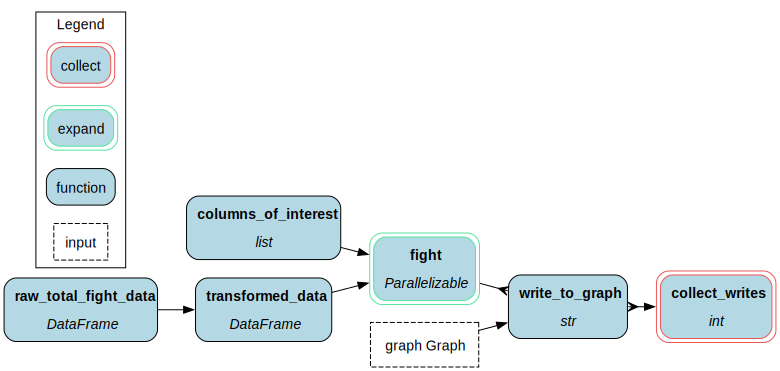

In [6]:
%%cell_to_module -m load_fights --display

import pandas as pd
import utils
from hamilton.htypes import Parallelizable, Collect
import falkordb

def raw_total_fight_data() -> pd.DataFrame:
    """Loads the raw fight data"""
    _df = pd.read_csv('../data/raw_total_fight_data.csv', delimiter=";")
    return _df

def transformed_data(raw_total_fight_data: pd.DataFrame) -> pd.DataFrame:
    """Does some light transformation on the data and adds some columns"""
    _df = raw_total_fight_data
    _df.last_round = _df.last_round.astype(int)
    _df.last_round_time = _df.last_round_time.apply(lambda x: utils.time_to_seconds(x))
    _df.date = _df.date.apply(lambda x: utils.date_to_timestamp(x))
    _df["Loser"] = _df.apply(
        lambda x: x["B_fighter"] if x["Winner"] == x["R_fighter"] else x["R_fighter"], axis=1)
    return _df


def columns_of_interest() -> list[str]:
    """Returns the columns that we're interested in processing"""
    return [
        "R_fighter", "B_fighter", 
        #    R_KD, B_KD, R_SIG_STR.,B_SIG_STR.,
        # R_SIG_STR_pct, B_SIG_STR_pct, R_TOTAL_STR., B_TOTAL_STR.,
        # R_TD, B_TD, R_TD_pct, B_TD_pct, R_SUB_ATT, B_SUB_ATT,
        # R_REV, B_REV, R_CTRL, B_CTRL, R_HEAD, B_HEAD, R_BODY,
        # B_BODY, R_LEG, B_LEG, R_DISTANCE, B_DISTANCE, R_CLINCH,
        # B_CLINCH, R_GROUND, B_GROUND, win_by, 
        "last_round",
        "last_round_time", "Format", "Referee", "date", "location",
        "Fight_type", "Winner", "Loser"
    ]


def fight(transformed_data: pd.DataFrame, 
        columns_of_interest: list[str],
        ) -> Parallelizable[pd.Series]:
    """Enables us to process each fight. We pass in a client along with each row"""
    for _idx, _row in transformed_data[columns_of_interest].iterrows():
        yield _row

def write_to_graph(fight: pd.Series, graph:  falkordb.Graph) -> str:
    _row, _graph = fight, graph
    # create referee
    q = "MERGE (:Referee {Name: $name})"
    _graph.query(q, {'name': _row.Referee if isinstance(_row.Referee, str) else ""})

    # create card
    q = "MERGE (c:Card {Date: $date, Location: $location})"
    _graph.query(q, {'date': _row.date, 'location': _row.location})

    # create fight
    q = """MATCH (c:Card {Date: $date, Location: $location})
           MATCH (ref:Referee {Name: $referee})
           MATCH (r:Fighter {Name:$R_fighter})
           MATCH (b:Fighter {Name:$B_fighter})
           CREATE (f:Fight)-[:PART_OF]->(c)
           SET f = $fight
           CREATE (f)-[:RED]->(r)
           CREATE (f)-[:BLUE]->(b)
           CREATE (ref)-[:REFEREED]->(f)
           RETURN ID(f)
        """
    f_id = _graph.query(q, {'date': _row.date, 'location': _row.location,
        'referee':  _row.Referee if isinstance(_row.Referee, str) else "", 'R_fighter': _row.R_fighter,
        'B_fighter': _row.B_fighter, 'fight': {'Last_round': _row.last_round,
            'Last_round_time': _row.last_round_time, 'Format': _row.Format,
            'Fight_type': _row.Fight_type}
        }).result_set[0][0]
    
    # mark winner & loser
    q = """MATCH (f:Fight) WHERE ID(f) = $fight_id
           MATCH (l:Fighter {Name:$loser})
           MATCH (w:Fighter {Name:$winner})
           CREATE (w)-[:WON]->(f), (l)-[:LOST]->(f)
        """
    _graph.query(q, {'fight_id': f_id, 'loser': _row.Loser, 'winner': _row.Winner if isinstance(_row.Winner, str) else ""})
    return "success"

def collect_writes(write_to_graph: Collect[str]) -> int:
    return len(list(write_to_graph))

# Exercise the pipelines

We set up the requisite objects and clients to run the pipelines.

In [7]:
import falkordb
from hamilton import driver
from hamilton.execution import executors

db = falkordb.FalkorDB(host='localhost', port=6379)
g  = db.select_graph("UFC")

# Clear previous graph
if "UFC" in db.list_graphs():
    g.delete()

### Note about the Hamilton UI
Hamilton comes with an [open source UI](https://hamilton.dagworks.io/en/latest/hamilton-ui/) that you can
surface information about your Hamilton executions. If you pull the docker containers
locally and uncomment adding the HamiltonTracker, then you'll see runs logged to it.

In [8]:
# if you have the Hamilton UI you can see progress:
# from hamilton_sdk import adapters
# tracker = adapters.HamiltonTracker(
#    project_id=44,  # modify this as needed
#    username="elijah@dagworks.io",
#    dag_name="load_fighters",
#    tags={"environment": "DEV", "team": "MY_TEAM", "version": "X"}
# )


# build the hamilton Driver
fighter_loader = (
    driver.Builder()
    .with_modules(load_fighters)
    .enable_dynamic_execution(allow_experimental_mode=True)
    .with_remote_executor(executors.MultiThreadingExecutor(5))
    # .with_adapters(tracker)   # <--- uncomment this to add tracker.
    .build()
)

fighter_loader.execute(["write_to_graph"], inputs={"graph": g})

{'write_to_graph': 3596}

In [9]:
# if you have the Hamilton UI you can see progress:
# from hamilton_sdk import adapters
# tracker = adapters.HamiltonTracker(
#    project_id=44,  # modify this as needed
#    username="elijah@dagworks.io",
#    dag_name="load_fights",
#    tags={"environment": "DEV", "team": "MY_TEAM", "version": "X"}
# )

fights_loader = (
    driver.Builder()
    .with_modules(load_fights)
    .enable_dynamic_execution(allow_experimental_mode=True)
    .with_remote_executor(executors.MultiThreadingExecutor(5))  # this will do 5 concurrent inserts
    # .with_adapters(tracker)   # <--- uncomment this to add tracker.
    .build()
)
fights_loader.execute(["collect_writes"], inputs={"graph": g})

{'collect_writes': 6012}